# Plotting SEM images with insets all in one

In [15]:
%matplotlib inline
## for interactive visualization
# %matplotlib nbagg  
from skimage import data, io, util, filters, color, draw, img_as_float, exposure
from skimage.exposure import match_histograms
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage.feature import canny
from skimage.segmentation import slic, chan_vese

from scipy import ndimage as ndi

import numpy as np
import matplotlib
from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from PIL import Image
import os 
import sys
import cv2
import pytesseract

debug = True #or 'False' when you do not want to debug

path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Plots/SEM/as_deposited"
os.chdir(path)
filess= os.listdir()
filess = [f for f in os.listdir(path) if f.endswith('tif')]

In [16]:
def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap = 'gray')
        ax.set_title(label)
        ax.axis('off')

def stretching(image, low = 2, high = 98): # low and high are set to their default values
    p2 = np.percentile(image, low)
    p98= np.percentile(image, high)
    return exposure.rescale_intensity(image, in_range=(p2,p98))

def adapteq(image, clip_limit=0.008):
    return exposure.equalize_adapthist(image, clip_limit=clip_limit)


L_asdep_006.tif
H_asdep_007.tif
H_asdep_003.tif
LH_asdep_002.tif
LH_asdep_003.tif
L_asdep.tif


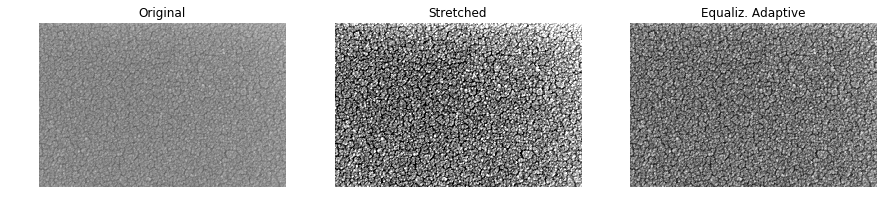

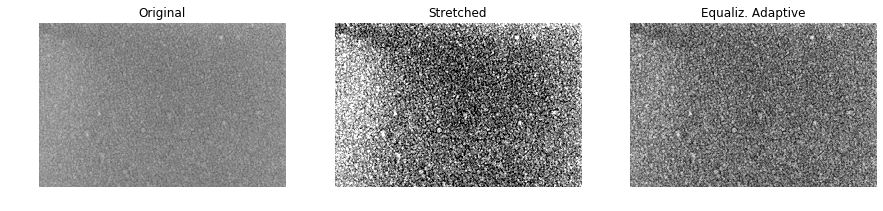

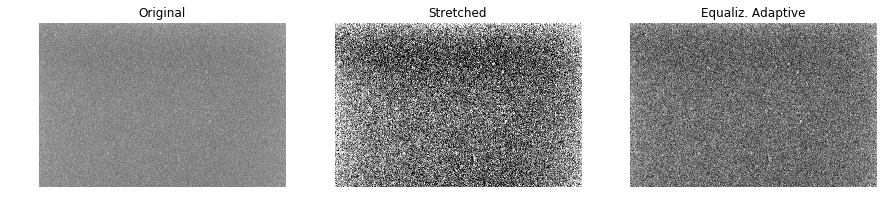

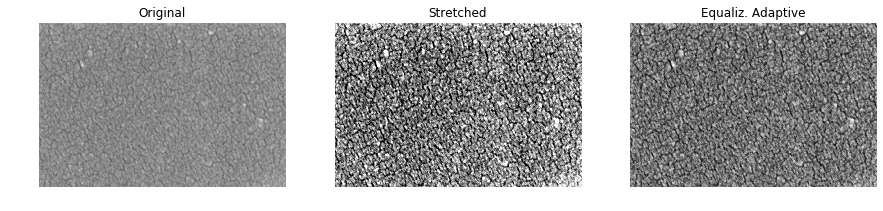

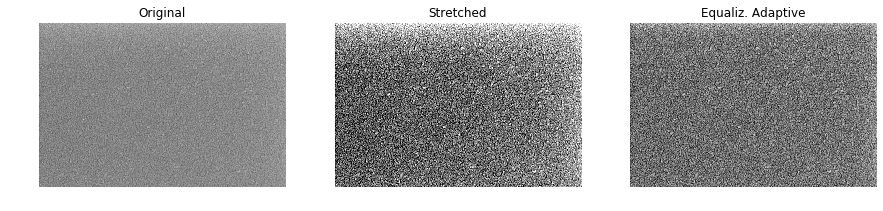

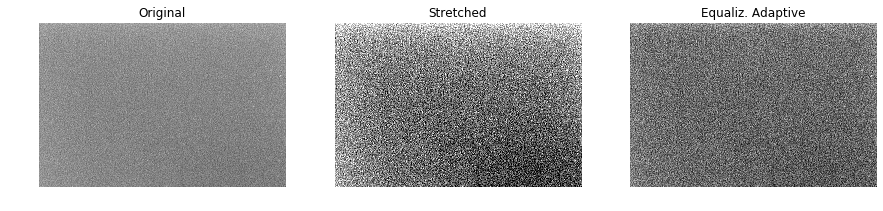

In [25]:
# Create a reference for the contrast adjustment:
reference = io.imread('H_asdep_003.tif', as_gray=True)
reference = img_as_float(reference[:1024,:])

for file in filess[:]:
    
    print(file)
    fname = f'{file[:-4]}'
        
    img = io.imread(file, as_gray=True)
    img = img_as_float(img[:1024,:])      # if I want to crop:    img = img[:1024,150:1174]

    img = exposure.match_histograms(img, reference)

    # Denoise and adjusted gamma:
    img = ndi.median_filter(img, size=3)

    # Apply contrast adjustment:
    img_str = stretching(img)
    img_equadapt = adapteq(img)
    
  
    # Match histograms to one single reference exposure: 
    matched = match_histograms(img, reference)
    
    imshow_all(img,img_str,img_equadapt, titles=['Original','Stretched','Equaliz. Adaptive'])
    
#     plt.savefig(f'{fname}_contrast_adjusted.png', dpi=450)

# Filtering
Source: https://github.com/scikit-image/scikit-image/pull/2647

In [ ]:
for file in filess[:]:
    
    fname = f'{file[:-4]}'
    
    #image load:
    img = io.imread(file, as_gray=True)
    img = img[:1024,:]     
    img_str = stretching(img)
    img_equadapt = adapteq(img)
    
     
# *** Apply filter:
    img_str_filtered = cycle_spin(img_str, func=denoise_wavelet, max_shifts=(1, 1))

    imshow_all(img_str,img_str_filtered, titles=['Stretched','Filtered'])
    plt.savefig(f'{fname}_filtered.png', dpi=450)
    
#     save_path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Plots/SEM/all_T/low-high/stretched" 
#     plt.savefig(os.path.join(save_path,f'{fname}_filtered.png'), dpi=450)

# Histogram:

Another way to plot histograms:

    #     fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(10, 5))
    #     ax0.hist(img.ravel())
    #     ax0.set_title("Original")
    #     ax1.hist(img_str.ravel())
    #     ax1.set_title("Stretched")
    #     ax2.hist(img_equadapt.ravel())
    #     ax2.set_title("Equalization Adaptive")
    
! In the following version, I can't set the number of bins to automatic, because the aspect ratio changes

In [ ]:
for file in filess[:]:
       
    fname = f'{file[:-4]}'  
     
    #image load:
    img = io.imread(file, as_gray=True)
    img = img[:1024,:]     
    img_str = stretching(img)
    img_equadapt = adapteq(img)
    
#*** Compose Histogram:
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # rescale:
    img_rescaled = rescale(img,1)
    img_str_rescaled = rescale(img_str,1)
    
    bins = 'auto'
    ax.hist(img_equadapt.ravel(), bins = bins , range = (0.1,0.9), density = True, stacked = True, alpha = 0.4, label = 'Equalization Adaptive')
    ax.hist(img_rescaled.ravel(), bins = bins , range = (0.1,0.9), density = True, stacked = True, alpha = 0.4, label = 'Original')
    ax.hist(img_str_rescaled.ravel(), bins = bins , range = (0.1,0.9), density = True, stacked = True, alpha = 0.4, label = 'Stretched')
    ax.legend()
    
#     save_path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Plots/SEM/all_T/low-high/" 
    plt.savefig(f'{fname}_hist_collapsed_and_rescaled.png', dpi=450)
    
    plt.close('all')

# Thresholding

$filters.threshold_$  choose filter by pressing tab, and then type argument between brackets, in this case img

- $Sauvola$ gives you the ideal thresholding for each pixel
- $Local$ is a pretty good one too


In [ ]:
for file in filess[:]:
    
    fname = f'{file[:-4]}'  
     
    #image load:
    img = io.imread(file, as_gray=True)
    img = img[:1024,:]     
    img_str = stretching(img)
    img_equadapt = adapteq(img)
    
#*** Define Threshold:
    
    #1:
    img_threshold = filters.threshold_sauvola(img)        
#     plt.imshow(img < img_threshold)

    #2:
    frangi = filters.frangi(img)
    roberts = filters.roberts(img)
    sobel = filters.sobel(img)
    scharr = filters.sobel(img)
    prewitt = filters.sobel(img)
    
    #Filtering step to help step n.3:
    denoised= ndi.median_filter(util.img_as_float(img), size=3)
    image_gamma = exposure.adjust_gamma(denoised, 0.9)

    #3:
    edge_canny = feature.canny(image_gamma, sigma = 2)
    
    plt.imshow(edge_canny, cmap = 'gray')

#     imshow_all(scharr,edge_canny, titles=['scharr','edge_canny'])
    
    save_path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Plots/SEM/as_deposited/2020" 
#     plt.savefig(os.path.join(save_path,f'{fname}_thresholds.png'), dpi=450)

# Supervised segmentation

- Active Contour (tried on a as-dep sample, did not really work well)
- Randow Walker  (not tried)
- Flood fill (doesn't work, not able to find module)

In [ ]:
for file in filess[:1]:
    
    img = io.imread(file, as_gray=True)
    img = img[:1024,:]      
    fname = f'{file[:-4]}'

    def circle_points(resolution, center, radius):
        """
        Generate points defining a circle on an image.
        """
        radians = np.linspace(0, 2*np.pi, resolution)

        c = center[1] + radius*np.cos(radians)
        r = center[0] + radius*np.sin(radians)

        return np.array([c, r]).T

    # Exclude last point because a closed path should not have duplicate points
    points = circle_points(400, [50, 110], 50)[:-1]

In [ ]:
    snake = seg.active_contour(img, points)

In [ ]:
    fig, ax = image_show(img)
    ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

# Unsupervised Segmentation

- $seg.slic_$ is not very useful for me. I had to use a huge number of segments to get just something vaguely useful, if at all
      # SLIC works in color
        img_slic = segmentation.slic(img, n_segments=60000)
      # label2rgb replaces each discrete label with the average interior color
        image_show(color.label2rgb(img_slic, img, kind='avg'));
- $seg.chan_vese_$ not very useful but not bad either! setted 'mu=1' on original img
        chan_vese = segmentation.chan_vese(img_equadapt, mu=1)
        fig, ax = image_show(img_equadapt)
        ax.imshow(chan_vese == 0, alpha=0.3);
But at the end all these require colors to work well.

In [ ]:
for file in filess[:1]:
    print(f"Plotting file: {file}")
    
    image_rescaled = rescale(img_str, 0.85)
    image_resized = resize(img_str, (img_str.shape[0] //1 , img_str.shape[1] // 1.181), anti_aliasing=True)
    image_downscaled = downscale_local_mean(img_str, (1, 1))

    fig, axes = plt.subplots(nrows=2, ncols=2)
    #f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))

    ax = axes.ravel()

    ax[0].imshow(img_str, cmap='viridis')
    ax[0].set_title("Original image")

    ax[1].imshow(image_rescaled, cmap='viridis')
    ax[1].set_title("Rescaled image (aliasing)")

    

    ax[0].set_xlim(0, 1301)
    ax[0].set_ylim(1024, 0)
    plt.tight_layout()
    plt.show()

    
#     fname = f'{file[:-4]}_stretched'
    
#     fname_svg = f'{fname}.svg'
#     fname_png = f'{fname}_cropped.png'
    
#     save_path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Plots/SEM/all_T/low-high/stretched"
    
#     plt.savefig(os.path.join(save_path,fname_svg),dpi=800)
#     plt.savefig(os.path.join(save_path,fname_png),dpi=800)